# Visualize different cohorts in BASMI data

* TODO: Filter for rehab patients
* TODO: Consider the effect of adding data to `no-treatment` cohort of patients who are later in disease progression$^1$


1. The problem here is that most patients start using no drugs and end up using drugs. However, the time (and age) is a definite factor in disease progression, and by adding data to the `no-treatment` cohort that is mostly later in disease progression we are inducing a bias in that cohort.

In [25]:
import sys
sys.path.append('../')

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import data_utils as util

import seaborn as sns

%matplotlib inline
%load_ext autoreload
%autoreload 2

sns.set()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load Demographics  and BASMI data

In [26]:
demo_df = pd.read_excel('../data/demographics and Biologics data.xlsx', index_col=0)

# Get year of birth for estimating age
year_of_birth = pd.DataFrame(demo_df['year of Birth'])

# Subselect and rename some columns
demo_df = demo_df[['patient_gender_id','patient_date_of_diagnosis']]
demo_df.rename(columns={'patient_gender_id': 'gender', 'patient_date_of_diagnosis': 'diagnosis_date'}, inplace=True)

basmi_df = pd.read_excel('../data/clean_basmi.xls', index_col=(0,1)).reset_index(level=1, drop=False)
basmi_df.head()

,Date,CRS,TWS,LSFS,LFS,IMS,BS,Drug
patient_id,,,,,,,,
40,1995-05-09,3,1,6,5,3,3.6,NaN
40,1995-06-01,3,1,8,5,3,4.0,NaN
40,1995-06-12,2,1,5,3,2,2.6,NaN
40,1995-11-02,1,1,3,4,2,2.2,NaN
40,1996-05-02,2,1,4,3,2,2.4,NaN


## Data Pre-processing & Setup

In [27]:
# Add year of birth to BASMI data
df = pd.merge(basmi_df, year_of_birth, left_index=True, right_index=True)

# Convert Drug to binary
df['Drug'] = df['Drug'].notnull()

# Add patient age using year of birth
df['Age'] = df['Date'].dt.year - df['year of Birth']
df.drop('year of Birth', axis=1, inplace=True)

# Bin age into 10 bins
bins = [np.floor(x) for x in np.linspace(df['Age'].values.min(), df['Age'].values.max(), 11)]
labels = range(1,11)
df['Age_cat'] = pd.cut(df['Age'], bins=bins, labels=labels)

df.head()

,Date,CRS,TWS,LSFS,LFS,IMS,BS,Drug,Age,Age_cat
patient_id,,,,,,,,,,
40,1995-05-09,3,1,6,5,3,3.6,False,48,5
40,1995-06-01,3,1,8,5,3,4.0,False,48,5
40,1995-06-12,2,1,5,3,2,2.6,False,48,5
40,1995-11-02,1,1,3,4,2,2.2,False,48,5
40,1996-05-02,2,1,4,3,2,2.4,False,49,5


## Split BASMI data into different cohorts:

* Treatment: Patients who underwent **any** treatment
* No Treatment: Patients who have **not** had any treatment

To be clear, consider the following example: Patient 40 entered the study and took no biologics and also did not undergo rehab for the first 12 years. However, after 12 years the patient started using a biologic drug. This means that the first 12 years of measurements of patient 40 will be added to the "no treatment" cohort, and the latter will be added to the "treatment" cohort. 



In [78]:
no_drugs_df = df[df['Drug'] == False]
drugs_df = df[df['Drug'] == True]

print('Drug Data: {}'.format(drugs_df.shape))
print('No Drugs Data: {}'.format(no_drugs_df.shape))

Drug Data: (1218, 10)
No Drugs Data: (13218, 10)


#### Visualize BS trajectories

* Consider only patients who did not take drugs
* Clip where (if) rehab done TODO
* Show BS score for age at entry

In [75]:
dfs = []
for patient_id, patient_df in no_drugs_df.groupby('patient_id'):
    
    rehab_date = patient_df[patient_df['Date'].diff().dt.days == 14]
    
    # If patient did rehab - clip the data at the date before going into rehab
    if not rehab_date.empty:
        # Date of rehab
        idx = rehab_date.Date.values[0]
        patient_df = patient_df[patient_df['Date'] < idx]
    dfs.append(patient_df)
    
no_treatment_df = pd.concat(dfs)
print('No Treatment Data: {}'.format(no_treatment_df.shape))
no_treatment_df.head()

No Treatment Data: (11228, 10)


,Date,CRS,TWS,LSFS,LFS,IMS,BS,Drug,Age,Age_cat
patient_id,,,,,,,,,,
40,1995-05-09,3,1,6,5,3,3.6,False,48,5
40,1995-06-01,3,1,8,5,3,4.0,False,48,5
40,1995-06-12,2,1,5,3,2,2.6,False,48,5
40,1995-11-02,1,1,3,4,2,2.2,False,48,5
40,1996-05-02,2,1,4,3,2,2.4,False,49,5


#### Show BS Score By Age

Plot the BS score by Age for all patients in the "No Treatment" cohort. The _mean_ BS score is taken for every year, to get one score per year for each patient.

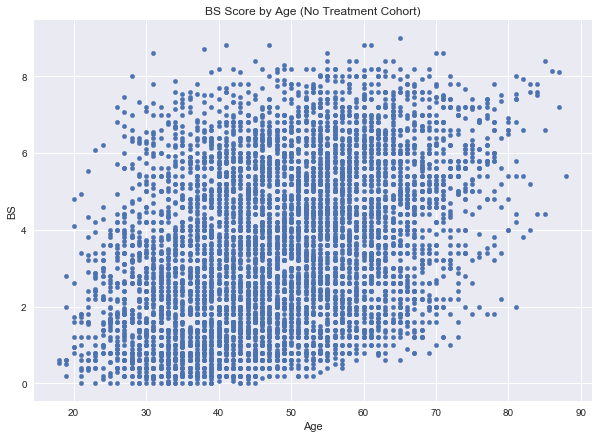

In [76]:
agg_dict = {'BS': 'mean', 'Age': min}
agg = no_treatment_df.groupby(['patient_id','Age']).agg(agg_dict)
agg.reset_index(level=1, drop=True)
agg.plot(x='Age', y='BS', kind='scatter', figsize=(10,7),
         title='BS Score by Age (No Treatment Cohort)')

#### Show BS by Age for first year in study

Now take only the BS score of the first year in the study for each patient in the "No Treatment" cohort

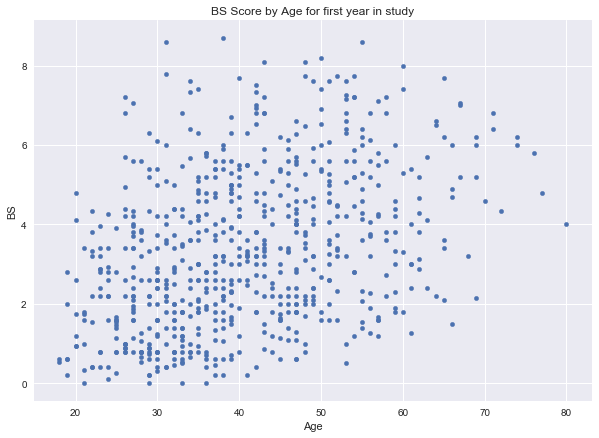

In [77]:
# Get only the first entry for each patient --> Age at entry
agg_at_entry = agg.groupby('patient_id').apply(lambda x: x.iloc[0])
agg_at_entry.plot(x='Age',y='BS', kind='scatter', figsize=(10,7),
                  title='BS Score by Age for first year in study')